## Notebook for figure 1
1. The figure of model architecture (.pdf)
2. Long native trials/*.csv
3. Learning comparison.csv
4. mapping = json.load(open("../../data/imagenet_label_to_wordnet_synset.json"))
5. behavior_mapping = json.load(open("../../data/wordnet_translation.json"))
6. recognition predictions

In [169]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [170]:
import json
from nltk.corpus import wordnet as wn
from matplotlib.gridspec import GridSpec
from mne.stats import permutation_t_test

# Define colors

In [171]:
phase_color = {"pre": "#1f77b4", "post": "#ff7f0e", "gray": "#888888", "catch": "#FFE6CC"}
ROICOLORS = {
    "EVC": "#00FF00",
    "HLVC": "#FF0000",
    "LOC": "#FF0033",
    "FC": "#FF3300",
    "Dorsal": "#0000FF",
    "FPN": "#FF00FF",
    "DMN": "#00FFFF",
    "Limbic": "#862D2D",
    "other": "#000000",
}
order = ["EVC", "LOC", "FC", "Dorsal", "FPN", "DMN"]

### B

In [172]:
path = "/Users/chris/projects/Nature2023MooneyScripts/results/long_native_trials/"

In [173]:
dfs = []

for synth_seed in range(1000):
    for model_seed in range(4):
        file_csv = path + f"/{synth_seed}_dinov2-base-imagenet1k-1-layer_seed{model_seed}.csv"
        loaded = pd.read_csv(file_csv)
        loaded["model_seed"] = model_seed
        loaded["synth_seed"] = synth_seed

        dfs.append(loaded)

df_b = pd.concat(dfs)
df_b["Accuracy"] = (df_b["Ground truth class"] == df_b["Predicted class"]).astype(int)
first_df = df_b[df_b["Time index"] == 0]
first_df = first_df[first_df["Image phase"] != "repetition"]

# Get phase performance
first_perf = first_df.groupby("Image phase").agg({"Accuracy": "mean"}).reset_index()

In [174]:
# Average over a trial
df_b = df_b.groupby(["synth_seed", "model_seed", "Image phase"]).mean().reset_index()

In [175]:
from scipy.stats import mannwhitneyu, ttest_1samp

# Test if:
# 1. Repetition > pre
# 2. Post > pre
# 3. Post > repetition
# 4. Gray > post
# 5. Gray < 0.845

pre_acc = df_b[df_b["Image phase"] == "pre"]["Accuracy"]
post_acc = df_b[df_b["Image phase"] == "post"]["Accuracy"]
repetition_acc = df_b[df_b["Image phase"] == "repetition"]["Accuracy"]
gray_acc = df_b[df_b["Image phase"] == "gray"]["Accuracy"]

# 1. Repetition > pre
comp1 = mannwhitneyu(repetition_acc, pre_acc)

# 2. Post > pre
comp2 = mannwhitneyu(post_acc, pre_acc)

# 3. Post > repetition
comp3 = mannwhitneyu(post_acc, repetition_acc)

# 4. Gray > post
comp4 = mannwhitneyu(gray_acc, post_acc)

# 5. Gray < 0.84
comp5 = ttest_1samp(gray_acc, 0.845)

repetition_acc.mean() - pre_acc.mean(), post_acc.mean() - pre_acc.mean(), post_acc.mean() - repetition_acc.mean(), gray_acc.mean() - post_acc.mean(), gray_acc.mean()

(0.03111428571428565,
 0.16624642857142857,
 0.13513214285714292,
 0.18273809523809537,
 0.8352226190476192)

In [176]:
0.65 - 0.49

0.16000000000000003

In [177]:
def plot_model_accuracy(df, ax):
    phase_colors = {
        "pre": "#1f77b4",
        "post": "#ff7f0e",
        "gray": "#888888",
        "repetition": "#d62728"
    }

    sns.violinplot(
        data=df,
        x="Image phase",
        y="Accuracy",
        order=["pre", "post", "gray", "repetition"],
        ax=ax,
        palette=phase_colors
    )

    ax.axhline(0.845, color="k", linestyle="--")
    ax.annotate("Color ImageNet 1k accuracy", xy=(0.0, 0.9))

    # Turn y ticks by 100x
    ax.set_yticks([0.5, 0.7, 0.845])
    ax.set_yticklabels([f"{100*x:.0f}%" for x in ax.get_yticks()])

    # Draw learning effect
    # Line from pre to between post and gray
    ax.plot([0, 1.6], [pre_acc.mean(), pre_acc.mean()], "k--")
    ax.plot([1, 1.6], [post_acc.mean(), post_acc.mean()], "k--")

    # Draw arrow between their means
    ax.annotate(
        "",
        xy=(1.6, pre_acc.mean()),
        xytext=(1.6, post_acc.mean()),
        arrowprops=dict(arrowstyle="<|-|>", lw=2),
    )

    # Find diff
    diff = post_acc.mean() - pre_acc.mean()
    ax.annotate(
        f"{100*diff:.2f}% (****)", xy=(1.7, (post_acc.mean() + pre_acc.mean()) / 2)
    )
    # ax.set_title("Model accuracy")

### C

In [178]:
# Run `plot_task_performance_compare_human.ipynb` and copy the table to clipboard
df_c = pd.read_clipboard()

In [179]:
def plot_learning_comparison_w_human(df, ax):
    # Aggregate by subject and source
    agg_df = df.drop(columns=["Image index"])
    agg_df = agg_df.groupby(["Subject", "Source", "Phase"]).mean(numeric_only=True).reset_index()

    sns.boxplot(data=agg_df, x="Source", y="Correct", hue="Phase", hue_order=["pre", "post"], ax=ax)

    # Plot the differences
    mean_pre_human = agg_df[(agg_df["Source"] == "Human") & (agg_df["Phase"] == "pre")]["Correct"].median()
    mean_post_human = agg_df[(agg_df["Source"] == "Human") & (agg_df["Phase"] == "post")]["Correct"].median()
    ax.plot([-0.4, -0.6], [mean_pre_human, mean_pre_human], color="k", linestyle="--")
    ax.plot([-0.6, 0.7], [mean_post_human, mean_post_human], color="k", linestyle="--")

    # Draw arrow between their means
    ax.annotate('', xy=(-0.6, mean_pre_human), xytext=(-0.6, mean_post_human), arrowprops=dict(arrowstyle='<|-|>', lw=2))
    ax.annotate(f'{100 * (mean_post_human - mean_pre_human):.2f}%', xy=(-0.57, 1.2 * (mean_post_human + mean_pre_human) / 2))

    # Plot the differences
    mean_pre_model = agg_df[(agg_df["Source"] == "Model") & (agg_df["Phase"] == "pre")]["Correct"].median()
    mean_post_model = agg_df[(agg_df["Source"] == "Model") & (agg_df["Phase"] == "post")]["Correct"].median()
    ax.plot([1-0.4, 1.5], [mean_pre_model, mean_pre_model], color="k", linestyle="--")
    ax.plot([0.7, 1.5], [mean_post_model, mean_post_model], color="k", linestyle="--")

    # Draw arrow between their means
    ax.annotate('', xy=(1.5, mean_pre_model), xytext=(1.5, mean_post_model), arrowprops=dict(arrowstyle='<|-|>', lw=2))
    ax.annotate(f'{100 * (mean_post_model - mean_pre_model):.2f}%', xy=(1.1, (mean_post_model + mean_pre_model) / 2))

    # Draw arrow between model and human post mean
    ax.annotate('', xy=(0.7, mean_post_human), xytext=(0.7, mean_post_model), arrowprops=dict(arrowstyle='<|-|>', lw=2))
    ax.annotate(f'{100 * (mean_post_human - mean_post_model):.2f}%', xy=(0.74, (mean_post_human + mean_post_model) / 2))

    # Make y axis Accuracy percentage
    ax.set_yticks(np.arange(0.35, 0.9, 0.1), [f"{int(100 * i)}%" for i in np.arange(0.35, 0.9, 0.1)])
    ax.set_ylabel("Accuracy")
    # ax.set_title("Model and human learning comparison")

    # No label
    ax.set_xlabel("")

## D

In [180]:
model_mean = 0.7847082138085975
human_mean = 0.4102395750584149
model_human_mean = 0.2892091242053731

ci_model = (0.71897814, 0.84214993)
ci_human = (0.28541688, 0.53299174)
ci_model_human = (0.19145832, 0.39773264)

In [181]:
mean_similarities = np.array([model_mean, human_mean, model_human_mean])
mean_similarities_ci = np.array([ci_model, ci_human, ci_model_human]).T
mean_similarities_ci = np.abs(mean_similarities_ci - mean_similarities)

### E

In [182]:
from pathlib import Path
import re

In [183]:
p = Path("/Users/chris/projects/Nature2023MooneyScripts/results/behavior_predictions")

# Iterate over the csv files
df_lst = []
for file in p.glob("*.csv"):
    df_d = pd.read_csv(file)

    # Only take CV, pivot
    df_d = df_d[df_d["perf_type"] == "CV"]

    # Drop the perf_type column
    df_d = df_d.drop(columns=["perf_type"])

    # Second column is performance
    perf_col = df_d.columns[1]
    feature_type = "_".join(perf_col.split("_")[:-1])

    # Write this column
    perf = df_d[perf_col].values[0]
    df_d["Score"] = perf
    df_d["Feature"] = feature_type

    # Phase
    if "pre" in file.name:
        df_d["Phase"] = "pre"
    elif "post" in file.name:
        df_d["Phase"] = "post"
    elif "gray" in file.name:
        df_d["Phase"] = "gray"
    else:
        raise ValueError("Unknown phase")
    
    # Compile the regex pattern for efficiency if you're going to use it multiple times
    pattern = re.compile(r"_seed(\d+)_")

    # Find all matches and extract the indices
    matches = pattern.findall(file.name)

    # Convert matches to integers (since they are strings)
    indices = [int(match) for match in matches]
    df_d["Seed"] = indices[0]

    # Drop column
    df_d = df_d.drop(columns=[perf_col])
    df_lst.append(df_d)

# Concatenate the dataframes
df_d = pd.concat(df_lst)

In [184]:
layer_df = df_d[df_d["Feature"].str.contains("layer") | df_d["Feature"].str.contains("logits") | df_d["Feature"].str.contains("cls")]

# Replace logits with layer_12
layer_df["Feature"] = layer_df["Feature"].replace("logits", "layer_13")
layer_df["Feature"] = layer_df["Feature"].replace("cls", "layer_12")
layer_df["Layer"] = layer_df["Feature"].apply(lambda x: int(x.split("_")[1]))

# Lineplot takes too long to plot. Let's pre-calculate the sem for each time index and phase
grouped = layer_df.groupby(["Layer", "Phase"])['Score'].agg(['mean', 'sem', 'count'])

# Calculate the 95% CI
z = 1.96  # Z-score for 95% CI
grouped['lower_95_ci'] = grouped['mean'] - z * grouped['sem']
grouped['upper_95_ci'] = grouped['mean'] + z * grouped['sem']

grouped = grouped.reset_index()[["Layer", "Phase", "mean", "lower_95_ci", "upper_95_ci"]]

/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_78269/3211154027.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df["Feature"] = layer_df["Feature"].replace("logits", "layer_13")
/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_78269/3211154027.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df["Feature"] = layer_df["Feature"].replace("cls", "layer_12")
/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_78269/3211154027.py:6: SettingWithCopyWarning: 
A value 

In [185]:
def plot_pred_by_layer(layer_df, grouped, ax):
    # Make dataset
    # [n_observations, p, phase]
    perfs = []
    for (subject, seed), sub_df in layer_df.groupby(["subject", "Seed"]):
        sub_df = sub_df.pivot(index="Layer", columns="Phase", values="Score")

        # Reorder phase
        sub_df = sub_df[["pre", "post", "gray"]]

        perfs.append(sub_df.values)

    # Data
    data = np.stack(perfs, axis=0)
    original_shape = data.shape

    # Flatten
    data = data.reshape(original_shape[0], -1)
    out = permutation_t_test(data-0.5, n_permutations=5000)[1]
    out = out.reshape(original_shape[1], original_shape[2])

    lines = []

    # Draw the significance stripe
    for phase in ["pre", "post", "gray"]:
        sub_df = grouped.query("Phase == @phase")
        line,  = ax.plot(sub_df["Layer"], sub_df["mean"], label=phase, color=phase_color[phase])
        ax.fill_between(sub_df["Layer"], sub_df["lower_95_ci"], sub_df["upper_95_ci"], alpha=0.3, color=phase_color[phase])

        lines.append(line)

    # Change 12 to "logits"
    ax.set_xticks(list(range(0, 12, 2))+[12, 13], list(range(0, 12, 2))+["CLS", "Logits"])

    # Plot a line for chance level
    ax.axhline(0.5, color="gray", linestyle="--")
    ax.annotate("Chance", (9.5, 0.48))
    ax.legend(loc="lower left")
    # ax.set_title("Recognition prediction performance")
    ax.set_ylabel("AUROC")

    ax.set_yticks([0.5, 0.6, 0.7])
    ax.set_yticklabels([f"{100*x:.0f}%" for x in ax.get_yticks()])

    # Rotate only every other xtick label
    for i, label in enumerate(ax.get_xticklabels()):
        if i >= 6:  # Selecting every other label
            label.set_rotation(45)  # Rotating the label

    # Draw significance stripe
    for idx in range(3):
        p_chosen = out[:, idx]
        for i, p_value in enumerate(p_chosen):
            if p_value < 0.01:
                # Adjust these values as needed
                xmin = max(i-0.5, 0)
                xmax = min(i+0.5, 13)
                ax.hlines(y=0.72-0.01*idx, xmin=xmin, xmax=xmax, color=lines[idx].get_color())

### Put together

Permuting 4999 times...


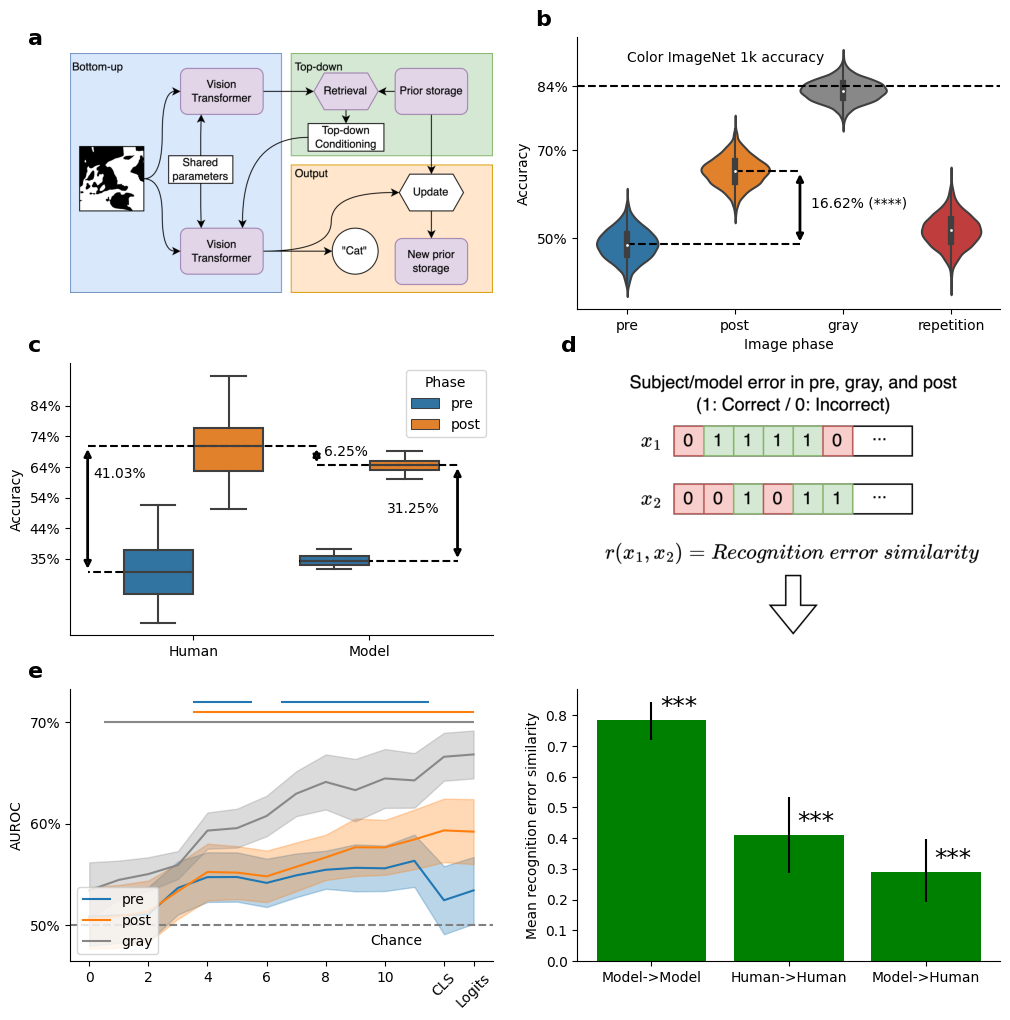

In [187]:
fig = plt.figure(figsize=(12, 12))

gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

ax1.text(
    -0.1, 1.1, "a", transform=ax1.transAxes, fontsize=16, fontweight="bold", va="top"
)

# Add png
ax1.imshow(
    plt.imread("/Users/chris/projects/Nature2023MooneyScripts/data/ModelSchematics.png")
)

# No spines or ticks
ax1.spines[["top", "bottom", "right", "left"]].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[0, 1])
ax2.spines[["top", "right"]].set_visible(False)
plot_model_accuracy(df_b, ax2)

# Mark B
ax2.text(
    -0.1, 1.1, "b", transform=ax2.transAxes, fontsize=16, fontweight="bold", va="top"
)

ax3 = fig.add_subplot(gs[1, 0])
ax3.spines[["top", "right"]].set_visible(False)
plot_learning_comparison_w_human(df_c, ax3)

# Mark C
ax3.text(
    -0.1, 1.1, "c", transform=ax3.transAxes, fontsize=16, fontweight="bold", va="top"
)

ax4 = fig.add_subplot(gs[1, 1])
ax4.text(
    -0.1, 1.1, "d", transform=ax4.transAxes, fontsize=16, fontweight="bold", va="top"
)
ax4.imshow(
    plt.imread(
        "/Users/chris/projects/Nature2023MooneyScripts/data/BehavioralSimilarity.png"
    )
)
ax4.spines[["top", "bottom", "right", "left"]].set_visible(False)
ax4.set_xticks([])
ax4.set_yticks([])

ax4_2 = fig.add_subplot(gs[2, 1])
plt.bar(
    ["Model->Model", "Human->Human", "Model->Human"],
    mean_similarities,
    yerr=mean_similarities_ci,
    color="green"
)
ax4_2.spines[["top", "right"]].set_visible(False)
ax4_2.set_ylabel("Mean recognition error similarity")
ax4_2.annotate("***", xy=(0 + 0.2, mean_similarities[0] + 0.02), ha="center", fontsize=18)
ax4_2.annotate("***", xy=(1 + 0.2, mean_similarities[1] + 0.02), ha="center", fontsize=18)
ax4_2.annotate("***", xy=(2 + 0.2, mean_similarities[2] + 0.02), ha="center", fontsize=18)

ax5 = fig.add_subplot(gs[2, 0])
ax5.spines[["top", "right"]].set_visible(False)
plot_pred_by_layer(layer_df, grouped, ax5)

# Mark E
ax5.text(
    -0.1, 1.1, "e", transform=ax5.transAxes, fontsize=16, fontweight="bold", va="top"
)

plt.savefig("/Users/chris/Desktop/figure1.pdf", dpi=1000, bbox_inches="tight")